In [1]:
import xymass
import numpy as np
import scipy
import astropy.units as u
%matplotlib inline
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
n_object=10000 #sample size
f_binary=0.5 #binary fraction

In [3]:
#draw sample of psoitions from specified density profile.
#Since these are positions of center of masses in binary systems, 
#r_scale must be specified with units via astropy

r2d=xymass.sample_r2d(size=n_object,model='plum',r_scale=100.*u.pc,ellipticity=0.,position_angle=0.) 

In [4]:
#draw sample from specified mass function.
#Since these are masses of primaries in binary systems, must specify units via astropy

m_min=0.1
mass_primary=xymass.sample_imf(size=n_object,model='kroupa',m_min=m_min).mass*u.M_sun

In [5]:
#add binary companions according to specified binary fraction with Raghavan etal. 2010 parameters to sample 2body orbits

r2d_with_binaries_raghavan=xymass.add_binaries_physical(r2d.r_xyz,mass_primary,f_binary=f_binary,\
                                               m_min=m_min,binary_model='Raghavan2010')

In [6]:
#add binary companions according to specified binary fraction with Duquennoy & Mayor(1991) parameters to sample 2body orbits

r2d_with_binaries_dm91=xymass.add_binaries_physical(r2d.r_xyz,mass_primary,f_binary=f_binary,\
                                           m_min=m_min,binary_model='DM91')

In [7]:
#add binary companions according to mass ratio, period and eccentricity distributions sampled by the user to sample 2body orbits

#get array of m_secondary / m_primary, sampled from uniform distribution subject to constraint M_2 > 0.1 Msun

mass_ratio=np.random.uniform(size=n_object,low=m_min/mass_primary.value,high=1.) 

#alternatively, if secondary mass is independent of primary mass, sample secondary mass here.  
#Can pass either mass_ratio or mass_secondary to add_binaries function
mass_secondary=xymass.sample_imf(size=n_object,model='kroupa',m_min=m_min).mass*u.M_sun 

#get array of orbital period (years), sampled from truncated log-normal distribution

period=10.**xymass.sample_normal_truncated(size=n_object,loc=5.03,scale=2.28,\
                                           min_value=-np.inf,max_value=np.inf)/364.25*u.yr 

#get array of orbital eccentricity, sampled from truncated log-normal distribution

eccentricity=xymass.sample_normal_truncated(size=n_object,loc=0.31,scale=0.17,min_value=0.,max_value=1.)
    
r2d_with_binaries_user=xymass.add_binaries_physical(r2d.r_xyz,mass_primary,f_binary=f_binary,m_min=m_min,\
                                           mass_ratio=mass_ratio,period=period,eccentricity=eccentricity) 

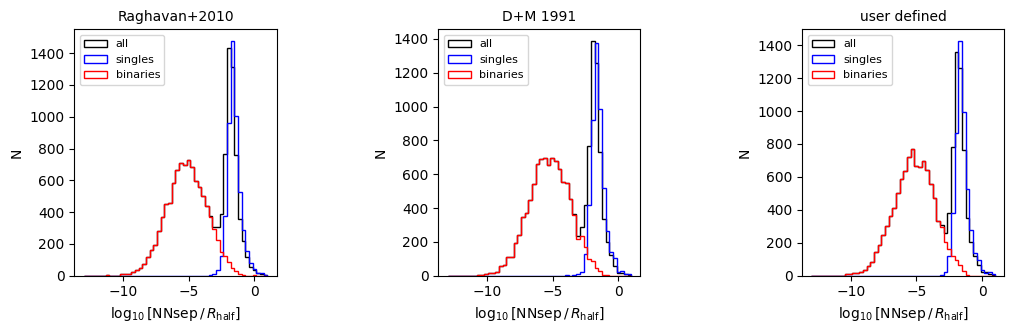

In [8]:
#plot nearest neighbor separation function for each case

fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(231)
ax2=fig.add_subplot(232)
ax3=fig.add_subplot(233)
#ax4=fig.add_subplot(224)
fig.subplots_adjust(wspace=0.8,hspace=0.5)

ax=[ax1,ax2,ax3]
title=['Raghavan+2010','D+M 1991','user defined']

i=0
for sample in [r2d_with_binaries_raghavan,r2d_with_binaries_dm91,r2d_with_binaries_user]:
    xy=np.c_[sample.r_xyz.T[0],sample.r_xyz.T[1]]
    xy_singles=np.c_[sample.r_xyz.T[0],sample.r_xyz.T[1]][sample.item==0]
    xy_binaries=np.c_[sample.r_xyz.T[0],sample.r_xyz.T[1]][sample.item>0]

    tree=scipy.spatial.KDTree(xy.to(r2d.rhalf_2d.unit).value)
    tree_singles=scipy.spatial.KDTree(xy_singles.to(r2d.rhalf_2d.unit).value)
    tree_binaries=scipy.spatial.KDTree(xy_binaries.to(r2d.rhalf_2d.unit).value)
    
    nn=tree.query(xy.value,k=2)[0].T[1]#gives array of NN distance for each item in sample
    nn_singles=tree_singles.query(xy_singles.value,k=2)[0].T[1]
    nn_binaries=tree_binaries.query(xy_binaries.value,k=2)[0].T[1]

    nn_0=tree_singles.query(xy_binaries.value,k=2)[0].T[1]
    nn_1=tree_binaries.query(xy_singles.value,k=2)[0].T[1]

    ax[i].hist(np.log10(nn/r2d.rhalf_2d.value),bins=50,histtype='step',density=False,color='k',label='all',range=[-13,1])
    ax[i].hist(np.log10(nn_singles/r2d.rhalf_2d.value),bins=50,histtype='step',density=False,color='b',label='singles',range=[-13,1])
    ax[i].hist(np.log10(nn_binaries/r2d.rhalf_2d.value),bins=50,histtype='step',density=False,color='r',label='binaries',range=[-13,1])
    ax[i].set_xlabel(r'$\log_{10}[\mathrm{NN sep}\,/\,R_{\rm half}]$',fontsize=10)
    ax[i].set_title(title[i],fontsize=10)
    ax[i].set_ylabel('N')
    ax[i].legend(loc=2,fontsize=8)

    i+=1
  
plt.show()


In [9]:
#Instead, add binary companions with separation functions specified by analytic model instead of orbit calculation

#specify lower and upper bounds of separation function

s_min=1.*u.AU #minimum separation
s_max=100000*u.AU #maximum separation

In [10]:
#add binary companions according to 2D separation function that is Opik's law
r2d_with_binaries_opik=xymass.add_binaries_func(r2d.r_xyz,\
                                              separation_func='opik',mass_primary=mass_primary,\
                                              mass_secondary=mass_secondary,f_binary=f_binary,s_min=s_min,\
                                              s_max=s_max,projected=True) #project=True if separation function is 2D, False if 3D


In [16]:
pl_alpha=2.001 #power law, index, defined so 2D separation function is dN/ds propto s^(-alpha)

#add binary companions according to 2D separation function that is power law
r2d_with_binaries_pl=xymass.add_binaries_func(r2d.r_xyz,\
                                              separation_func='pl',mass_primary=mass_primary,\
                                              mass_secondary=mass_secondary,f_binary=f_binary,s_min=s_min,\
                                              s_max=s_max,alpha=pl_alpha,projected=True) #project=True if separation function is 2D, False if 3D


In [17]:
bpl_s_break=100.*u.AU #broken power law, break separation
bpl_alpha1=1.01 #broken power law, index at s < s_break
bpl_alpha2=2. #broken power law, index at s > s_break

#add binary companions according to 2D separation function that is broken power law
r2d_with_binaries_bpl=xymass.add_binaries_func(r2d.r_xyz,\
                                               separation_func='bpl',mass_primary=mass_primary,\
                                               f_binary=f_binary,mass_ratio=mass_ratio,s_min=s_min,\
                                               s_max=s_max,s_break=bpl_s_break,alpha1=bpl_alpha1,\
                                               alpha2=bpl_alpha2,projected=True) #project=True if separation function is 2D, False if 3D


In [18]:
lognormal_loc=100.*u.AU #linear value corresponding to mean of log-normal separation distribution
lognormal_scale=50.*u.AU #linear value corresponding to standard deviation of log-normal separation distribution

#add binary companions according to 3D separation function that is lognormal
r2d_with_binaries_lognormal=xymass.add_binaries_func(r2d.r_xyz,\
                                                     separation_func='lognormal',mass_primary=mass_primary,\
                                                     mass_secondary=mass_secondary,f_binary=f_binary,\
                                                     s_min=s_min,s_max=s_max,loc=lognormal_loc,\
                                                     scale=lognormal_scale,projected=False) #project=True if separation function is 2D, False if 3D


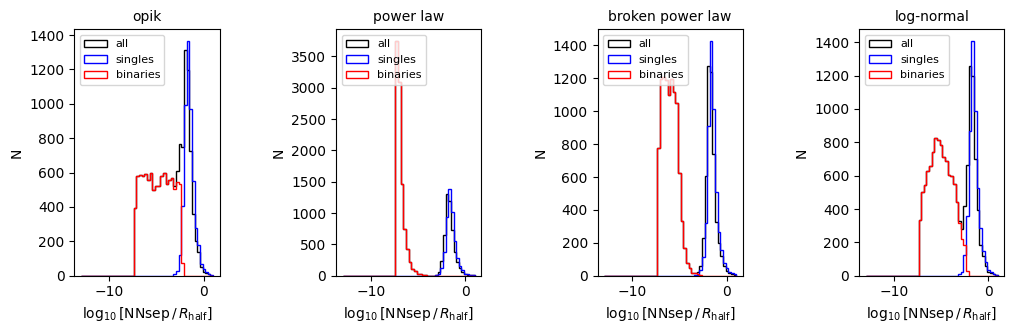

In [19]:
#plot nearest neighbor separation function for each case

fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(241)
ax2=fig.add_subplot(242)
ax3=fig.add_subplot(243)
ax4=fig.add_subplot(244)
fig.subplots_adjust(wspace=0.8,hspace=0.5)

ax=[ax1,ax2,ax3,ax4]
title=['opik','power law','broken power law','log-normal']

i=0
for sample in [r2d_with_binaries_opik,r2d_with_binaries_pl,r2d_with_binaries_bpl,r2d_with_binaries_lognormal]:
    xy=np.c_[sample.r_xyz.T[0],sample.r_xyz.T[1]]
    xy_singles=np.c_[sample.r_xyz.T[0],sample.r_xyz.T[1]][sample.item==0]
    xy_binaries=np.c_[sample.r_xyz.T[0],sample.r_xyz.T[1]][sample.item>0]

    tree=scipy.spatial.KDTree(xy.to(r2d.rhalf_2d.unit).value)
    tree_singles=scipy.spatial.KDTree(xy_singles.to(r2d.rhalf_2d.unit).value)
    tree_binaries=scipy.spatial.KDTree(xy_binaries.to(r2d.rhalf_2d.unit).value)
    
    nn=tree.query(xy.value,k=2)[0].T[1]#gives array of NN distance for each item in sample
    nn_singles=tree_singles.query(xy_singles.value,k=2)[0].T[1]
    nn_binaries=tree_binaries.query(xy_binaries.value,k=2)[0].T[1]
    nn_0=tree_singles.query(xy_binaries.value,k=2)[0].T[1]
    nn_1=tree_binaries.query(xy_singles.value,k=2)[0].T[1]
            
    ax[i].hist(np.log10(nn/r2d.rhalf_2d.value),bins=50,histtype='step',density=False,color='k',label='all',range=[-13,1])
    ax[i].hist(np.log10(nn_singles/r2d.rhalf_2d.value),bins=50,histtype='step',density=False,color='b',label='singles',range=[-13,1])
    ax[i].hist(np.log10(nn_binaries/r2d.rhalf_2d.value),bins=50,histtype='step',density=False,color='r',label='binaries',range=[-13,1])
    ax[i].set_xlabel(r'$\log_{10}[\mathrm{NN sep}\,/\,R_{\rm half}]$',fontsize=10)
    ax[i].set_title(title[i],fontsize=10)
    ax[i].set_ylabel('N')
    ax[i].legend(loc=2,fontsize=8)

    i+=1
  
plt.show()
